In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from pathlib import Path
import tqdm.notebook as tqdm
import multiprocessing

Welcome to JupyROOT 6.20/06


In [2]:
N_cpu=multiprocessing.cpu_count()
N_Threads = "%d" % (N_cpu-0)

In [3]:
def make_histo(Data_array,Title,nbins,xmin,xmax,save=True):
    Histo = ROOT.TH1F(Title,Title,nbins,xmin,xmax)
    for value in Data_array:
        Histo.Fill(value)

    Canv=ROOT.TCanvas()
    Histo.Draw()
    
    if save:
        Image_name=Title + '_Histo.pdf'
        Canv.Print(Image_name)
    
    return Histo, Canv

In [3]:
#name='gold_47_SC_90m_211220'
#name.split('_')
#
#angle=int(name.split('_')[1])*(1 if name.split('_')[2]=='DC' else -1)
#
#file=open('gold_47_SC_90m_211220/Stat_gold_47_SC_90m_211220.txt')
#line=file.readlines()
#for l in line:
#    if (l.startswith("Readout_time")):
#        time=float(l.split('=')[1].strip()[:-1])
#    if (l.startswith("Strobe")):
#        Strobe=int(l.split('=')[1].strip()[:-1])
#    if (l.startswith("Gap")):
#        Gap=int(l.split('=')[1].strip()[:-1])
#        
#weight=3600*(Gap+Strobe)/(Strobe*time)
#
#os.system("python Packet_analyzer.py -f gold_47_SC_90m_211220 -p -A DB -d 1 10 -b 1000 -s %i -w %f " % (angle,weight))


# Analysis on a specific dataset

In [4]:
#files=os.listdir('Data/')
#for name in files:
#    if name.startswith("gold_11"):
#        angle=int(name.split('_')[1])*(1 if name.split('_')[2]=='DC' else -1)
#
#        file=open("Data/"+name+"/Stat_"+name+".txt")
#        line=file.readlines()
#        for l in line:
#            if (l.startswith("Readout_time")):
#                time=float(l.split('=')[1].strip()[:-1])
#            if (l.startswith("Strobe")):
#                Strobe=int(l.split('=')[1].strip()[:-1])
#            if (l.startswith("Gap")):
#                Gap=int(l.split('=')[1].strip()[:-1])
#                
#        #weight that gives count/hour
#        weight=3600*(Gap+Strobe)/(Strobe*time)
#
#        os.system("python Packet_analyzer.py -Df Data -f " + name + " -p -A DB -d 1 10 -b 1000 -NThr " + N_Threads + " -s %i -w %f " % (angle,weight))

In [93]:
#! $ROOTSYS/bin/hadd Tot_63_2.root Analyzed_Data/gold_*/*.root
ROOT.disableJSVis()

In [4]:
#Geometry parameters
px_center=547
py_center=251
ALPIDE_center   = -17   #Steps
ALPIDE_distance = 78.63 #mm
ALPIDE_width    = 30    #mm
ALPIDE_height   = 13.8    #mm

Data_folder="Data"

th_max = 1.41
th_min = -1.41
thbins=300

ymin=10
ymax=490
xmin=10
xmax=1013

ETHist = ROOT.TH1F('ETHist', 'Exposition time',thbins,th_min,th_max)

files=os.listdir(Data_folder + "/")

with tqdm.tqdm(total=len(files)) as pbar:
    for name in files:
        pbar.update(1)
        if name.startswith("gold_alpide"):
        #if name.startswith("gold_alpide_3_SC_10m"):
            #for gold_ files
            #angle=int(name.split('_')[1])*(1 if name.split('_')[2]=='DC' else -1)
            # for gold_alpide files
            angle=int(name.split('_')[2])*(1 if name.split('_')[3]=='DC' else -1)
            file=open(Data_folder+"/"+name+"/Stat_"+name+".txt")
            line=file.readlines()
            for l in line:
                if (l.startswith("Readout_time")):
                    time=float(l.split('=')[1].strip()[:-1])
                if (l.startswith("Strobe")):
                    Strobe=int(l.split('=')[1].strip()[:-1])
                if (l.startswith("Gap")):
                    Gap=int(l.split('=')[1].strip()[:-1])

            exp_time=(Strobe*time)/(Gap+Strobe)


            for x in range(xmin,xmax,1):
                for y in range(ymin,ymax,1):
                    xd=(x - px_center)*ALPIDE_width/1024
                    yd=np.sqrt(((y - py_center)*ALPIDE_height/512)**2+(ALPIDE_distance)**2)
                    Theta=np.arctan2(xd,yd)+(angle+ALPIDE_center)*0.9*np.pi/180
                    #Theta=np.arctan2(xd,ALPIDE_distance)+(angle+ALPIDE_center)*0.9*np.pi/180

                    ETHist.Fill(Theta,exp_time)

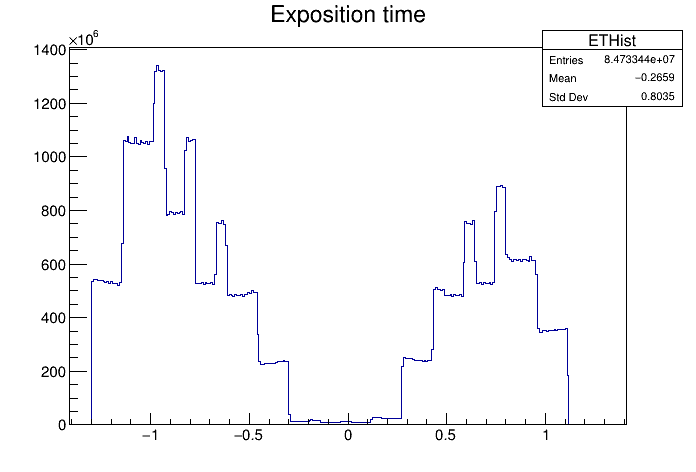

In [5]:
ETC = ROOT.TCanvas()

#ETHist.Draw('COLZ')
ETHist.Draw('HIST')
#ETC.SetLogy()
ETC.Draw()

In [30]:
ALPIDE_norm=np.zeros(ETHist.GetNbinsX()+1)

for i in range(ETHist.GetNbinsX()+1):
    ALPIDE_norm[i]=ETHist.GetBinContent(i)

# Analysis with normalization (time and Strobe parameters)

In [40]:
th_max
#int(301*(-1.3)/(th_max-th_min)+150)

1.1129399538040161

In [29]:
#normalization array from -180° to 180° [steps]
#ALPIDE_norm=np.zeros(201)
Data_folder="Data"

Run_Analysis = True
Force_Analysis = True

#load files of a cartain dataset
files=os.listdir(Data_folder + "/")

with tqdm.tqdm(total=len(files)) as pbar:
    for name in files:
        pbar.update(1)
        if name.startswith("gold_alpide"):
        #if name.startswith("gold_alpide_3_SC_10m"):
            #for gold_ files
            #angle=int(name.split('_')[1])*(1 if name.split('_')[2]=='DC' else -1)
            # for gold_alpide files
            angle=int(name.split('_')[2])*(1 if name.split('_')[3]=='DC' else -1)

            #os.system("python Packet_analyzer.py -f " + name + " -p -b 1000 -s %i -w %f" % (angle,weight))
            root_file=Path("Analyzed_Data/"+name+"/"+name+".root")
            root_file_existence_flag=root_file.is_file()
            if (Run_Analysis and not root_file_existence_flag) or Force_Analysis:
                Args = "-Df "+Data_folder+" -f "+name+" -p -A DB -NThr "+N_Threads+" -d 3 15 -s %i"%(angle)
                %run 'Packet_analyzer_test.py' {Args}
                #%run 'Packet_analyzer-Copy2.py' {Args}
            


gold_alpide_77_DC_2h_run4_120121: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

gold_alpide_37_DC_10m_run11_090121: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

gold_alpide_13_SC_120m_run6_080121: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

gold_alpide_43_SC_240m_run1_040121: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

gold_alpide_53_SC_240m_run4_020121: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

gold_alpide_43_SC_240m_run8_040121: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

gold_alpide_27_DC_5m_run6_090121: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]

gold_alpide_23_SC_120m_run7_070121: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

gold_alpide_67_DC_2h_run1_110121: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

gold_alpide_57_DC_2h_run12_100121: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

gold_alpide_37_DC_10m_run17_090121: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

gold_alpide_27_DC_5m_run4_090121: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]

gold_alpide_

In [7]:
#merge all the TTree
! $ROOTSYS/bin/hadd -f Tot_data_tree/Tot_Alide_53SC_77DC_test.root Analyzed_Data/gold_alpide*/*.root 
#! $ROOTSYS/bin/hadd -f Tot_data_tree/Tree_0.root Analyzed_Data/gold_alpide_17_DC_5m*/*.root

hadd Target file: Tot_data_tree/Tot_Alide_53SC_77DC_test.root
hadd compression setting for all output: 1
hadd Source file 1: Analyzed_Data/gold_alpide_13_SC_120m_run10_080121/gold_alpide_13_SC_120m_run10_080121.root
hadd Source file 2: Analyzed_Data/gold_alpide_13_SC_120m_run1_080121/gold_alpide_13_SC_120m_run1_080121.root
hadd Source file 3: Analyzed_Data/gold_alpide_13_SC_120m_run2_080121/gold_alpide_13_SC_120m_run2_080121.root
hadd Source file 4: Analyzed_Data/gold_alpide_13_SC_120m_run3_080121/gold_alpide_13_SC_120m_run3_080121.root
hadd Source file 5: Analyzed_Data/gold_alpide_13_SC_120m_run4_080121/gold_alpide_13_SC_120m_run4_080121.root
hadd Source file 6: Analyzed_Data/gold_alpide_13_SC_120m_run5_080121/gold_alpide_13_SC_120m_run5_080121.root
hadd Source file 7: Analyzed_Data/gold_alpide_13_SC_120m_run6_080121/gold_alpide_13_SC_120m_run6_080121.root
hadd Source file 8: Analyzed_Data/gold_alpide_13_SC_120m_run7_080121/gold_alpide_13_SC_120m_run7_080121.root
hadd Source file 9: A

In [8]:
#ROOT.enableJSVis()
ROOT.disableJSVis()

#convert the TTree in np arrays
root_file_1  =ROOT.TFile.Open("Tot_data_tree/Tot_Alide_53SC_77DC_test.root")
#root_file_1  =ROOT.TFile.Open("Tot_data_tree/Tree_20.root")
Data_tree    = root_file_1.Get("tree")
#Data_tree.Print()

Noise_points = Data_tree.AsMatrix(['Rnoise'])
Areas        = Data_tree.AsMatrix(['Rareas'])
Means        = Data_tree.AsMatrix(['Rmeanx','Rmeany'])
Theta        = Data_tree.AsMatrix(['Rtheta'])
#Weight       = Data_tree.AsMatrix(['Rweight'])
Exptime      = Data_tree.AsMatrix(['Reetime'])
Ratios       = Data_tree.AsMatrix(['Rratios'])

/home/gabriele/anaconda3/envs/rootenv/lib/python3.8/site-packages/ROOT.py:352: FutureWarning: Instantiating a function template with parentheses ( f(type1, ..., typeN) ) is deprecated and will not be supported in a future version of ROOT. Instead, use square brackets: f[type1, ..., typeN]
  flat_matrix_ptr = _root.ROOT.Internal.RDF.GetVectorAddress(dtype)(flat_matrix)


475.50959190174933 257.97240436300365


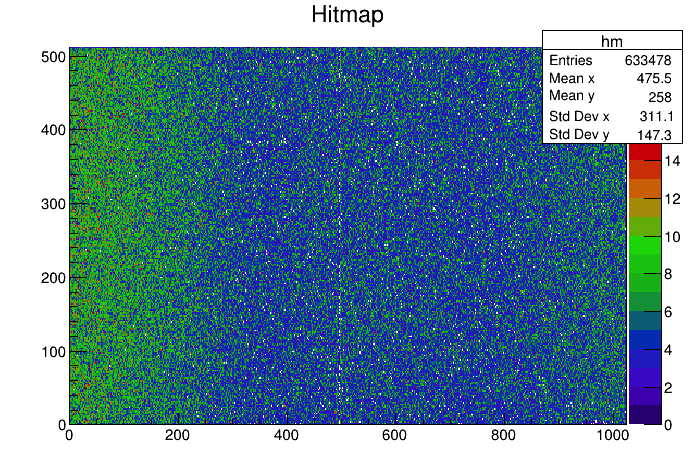

In [9]:
hm = ROOT.TH2D('hm','Hitmap',512,0,1024,256,0,512)

for coordinate in Means:
    hm.Fill(coordinate[0],coordinate[1])
    
ROOT.gStyle.SetPalette(107)
    
HC=ROOT.TCanvas()
hm.Draw('COLZ')
HC.Draw()

print(np.mean(Means[:,0]), np.mean(Means[:,1]))

Info in <TCanvas::Print>: pdf file Area_Histo.pdf has been created
Info in <TCanvas::Print>: pdf file PCA_Ratio_Histo.pdf has been created


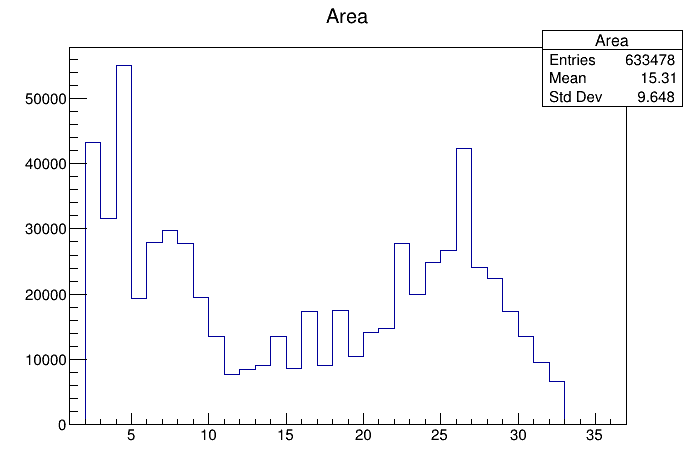

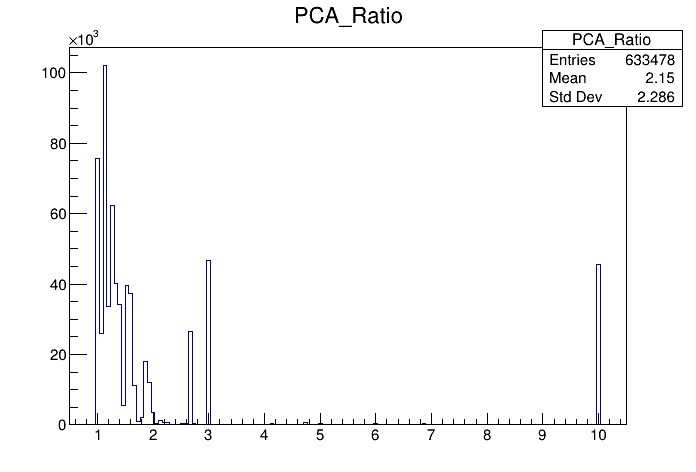

In [10]:
ar_max=int(np.amax(Areas))
ar_max=37
nbins=int((ar_max-1))
ArHist,AC=make_histo(Areas,'Area',nbins,1,ar_max)
AC.Draw()

r_max=(np.amax(Ratios)+0.5)
nbins=150
RHist,RC=make_histo(Ratios,'PCA_Ratio',nbins,0.5,r_max)
RC.Draw()

In [65]:
Area_thr=13
Ratio_thr=3.21

mask_thr =  np.logical_and (np.squeeze(Areas)      > Area_thr, np.squeeze(Ratios)     < Ratio_thr)
mask_x   =  np.logical_and (np.squeeze(Means[:,0]) > xmin    , np.squeeze(Means[:,0]) < xmax     )
mask_y   =  np.logical_and (np.squeeze(Means[:,1]) > ymin    , np.squeeze(Means[:,1]) < ymax     )

mask = np.logical_and(mask_thr, np.logical_and(mask_x, mask_y))


Areas_disc  = Areas [mask]
Means_disc  = Means [mask]
Theta_disc  = Theta [mask]
#Weight_disc = Weight[mask]
Exptime_disc= Exptime[mask]
Ratios_disc = Ratios[mask]


#A_disc_index = np.where  (Areas<Area_thr)
#Areas_disc   = np.delete (Areas ,A_disc_index)
#Means_disc   = np.delete (Means ,A_disc_index,axis=0)
#Theta_disc   = np.delete (Theta ,A_disc_index)
#Weight_disc  = np.delete (Weight,A_disc_index)
#Ratios_disc  = np.delete (Ratios,A_disc_index)

#R_disc_index=np.where (Ratios_disc>Ratio_thr)
#Areas_disc  =np.delete(Areas_disc,R_disc_index)
#Means_disc  =np.delete(Means_disc,R_disc_index,axis=0)
#Theta_disc  =np.delete(Theta_disc,R_disc_index)
#Weight_disc =np.delete(Weight_disc,R_disc_index)
#Ratios_disc =np.delete(Ratios_disc,R_disc_index)

In [66]:
ALPIDE_norm[12]

0.0

# Find profile center

In [85]:
from scipy.optimize import curve_fit

def parabola(x, a, b, c):
    return a*x**2+b*x+c

alpide_data   = []
alpide_weight = []

for value in Theta_disc:
    alpide_data.append(value*180/np.pi)
    #alpide_weight.append(1/(ALPIDE_norm[int(value*180/(np.pi)/0.9+100)]))
    alpide_weight.append(1/ALPIDE_norm[int((thbins+1)*(value)/(th_max-th_min)+thbins/2)+1])
    
alpide_data   = np.array(alpide_data  )
alpide_weight = np.array(alpide_weight)
    
n,bins,patches=plt.hist(alpide_data, weights=alpide_weight, bins=500, density=True, label="data")
plt.close()

mask_center = np.logical_and (bins      >= -4, bins <= 4)
bins_center = bins[mask_center]
n_center    = n[mask_center[:-1]]

half_bin   = (bins_center[1]-bins_center[0])/2
popt, pcov = curve_fit(parabola, bins_center+half_bin, n_center)
center     = -popt[1]/(2*popt[0])

print('Profile center=%1.3f°' % center)

alpide_data_centered=alpide_data-center

Profile center=0.375°


In [68]:
#t_max = (np.amax(Exptime_disc))
#t_min = (np.amin(Exptime_disc))
#nbins  = 10
#th_max = (np.amax(Theta_disc))
#th_min = (np.amin(Theta_disc))
#thbins=600
#
#ETHist = ROOT.TH1F('ThHist', 'Theta weighted',thbins,th_min,th_max)
##ETHist = ROOT.TH2F('ThHist', 'Theta weighted',nbins,t_min,t_max,800,th_min,th_max)
#
#for value,time in zip(Theta_disc,Exptime_disc):
#    #ThHist.Fill(value,weight/(ALPIDE_norm[int(value*180/(np.pi)/0.9+100)]))
#    ETHist.Fill(value,time)
#    #ThHist.Fill(value,weight)
#    
#ETHist.SetStats(False)
#    
#ETC = ROOT.TCanvas()
#
##ETHist.Draw('COLZ')
#ETHist.Draw('HIST')
##ETC.SetLogy()
#ETC.Draw()
#TC.Print('Graph_images/Theta_histo.png')

Warning in <TFile::Append>: Replacing existing TH1: ThHist (Potential memory leak).


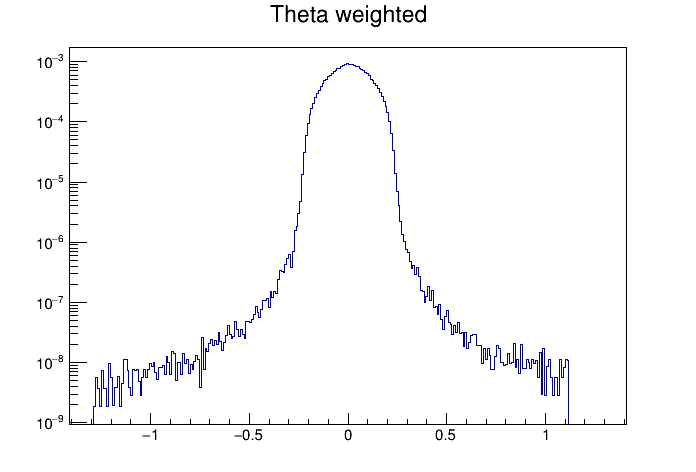

In [86]:
ThHist = ROOT.TH1F('ThHist', 'Theta weighted',thbins,th_min,th_max)


for value in Theta_disc:
    #ThHist.Fill(value,weight/(ALPIDE_norm[int(value*180/(np.pi)/0.9+100)]))
    #ThHist.Fill(value-center*np.pi/180)
    ThHist.Fill(value)
    
ThHist.Divide(ThHist,ETHist)
    
ThHist.SetStats(False)
    
TC = ROOT.TCanvas()

ThHist.Draw('HIST')
TC.SetLogy()
TC.Draw()
#TC.Print('Graph_images/Theta_histo.png')

Warning in <TFile::Append>: Replacing existing TH1: ThHist (Potential memory leak).


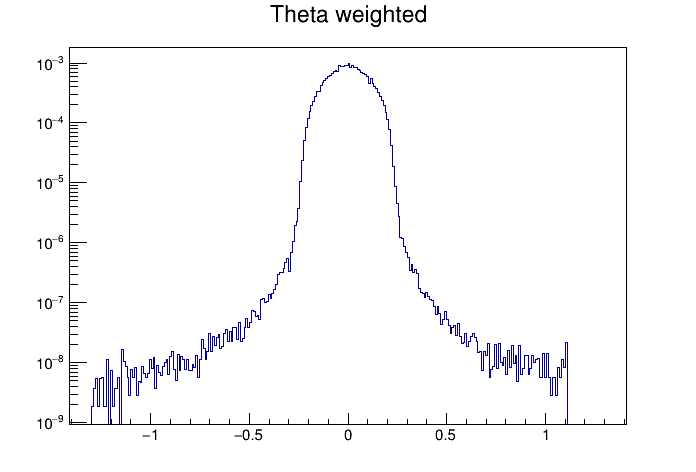

In [87]:
nbins  = 300

ThHist = ROOT.TH1F('ThHist', 'Theta weighted',nbins,th_min,th_max)


for value in Theta_disc:
    #ThHist.Fill(value,weight/(ALPIDE_norm[int(value*180/(np.pi)/0.9+100)]))
    ThHist.Fill(value-center*np.pi/180,1/(ALPIDE_norm[int((thbins+1)*(value)/(th_max-th_min)+thbins/2)+1]))
    #ThHist.Fill(value,weight)
    
ThHist.SetStats(False)
    
TC = ROOT.TCanvas()

ThHist.Draw('HIST')
TC.SetLogy()
TC.Draw()
#TC.Print('Graph_images/Theta_histo.png')

Warning in <TFile::Append>: Replacing existing TH1: Area (Potential memory leak).
Info in <TCanvas::Print>: pdf file Area_Histo.pdf has been created
Info in <TCanvas::Print>: png file Area_histo.png has been created
Warning in <TFile::Append>: Replacing existing TH1: Ratios (Potential memory leak).
Info in <TCanvas::Print>: pdf file Ratios_Histo.pdf has been created


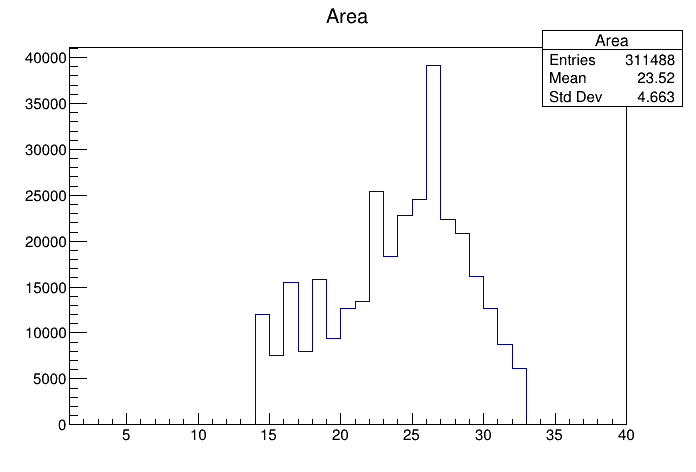

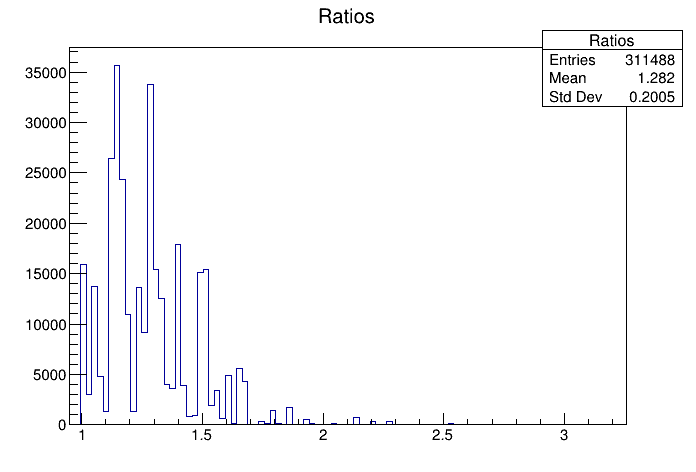

In [88]:
ar_max = int(np.amax(Areas_disc))
nbins  = int(ar_max)

ArHist,AC=make_histo(Areas_disc,'Area',nbins,1,ar_max+1)
AC.Draw()
AC.Print('Area_histo.png')

r_max   = np.amax(Ratios_disc)
nbins   = 100


RHist,RC=make_histo(Ratios_disc,'Ratios',nbins,0.95,r_max+0.05)
RHist.Draw()
RC.Draw()


#MxHist = ROOT.TH1F('MxHist', 'X Means',16,0,1023)
#
#for value in Means_disc[:,0]:
#    MxHist.Fill(value)
#
#MxC=ROOT.TCanvas()
#MxHist.Draw()
#MxC.Draw()

## Compare with simulation

In [72]:
x_mean = np.average(np.ndarray.flatten(alpide_data), weights= alpide_weight)
x_mean

0.3509252547479231

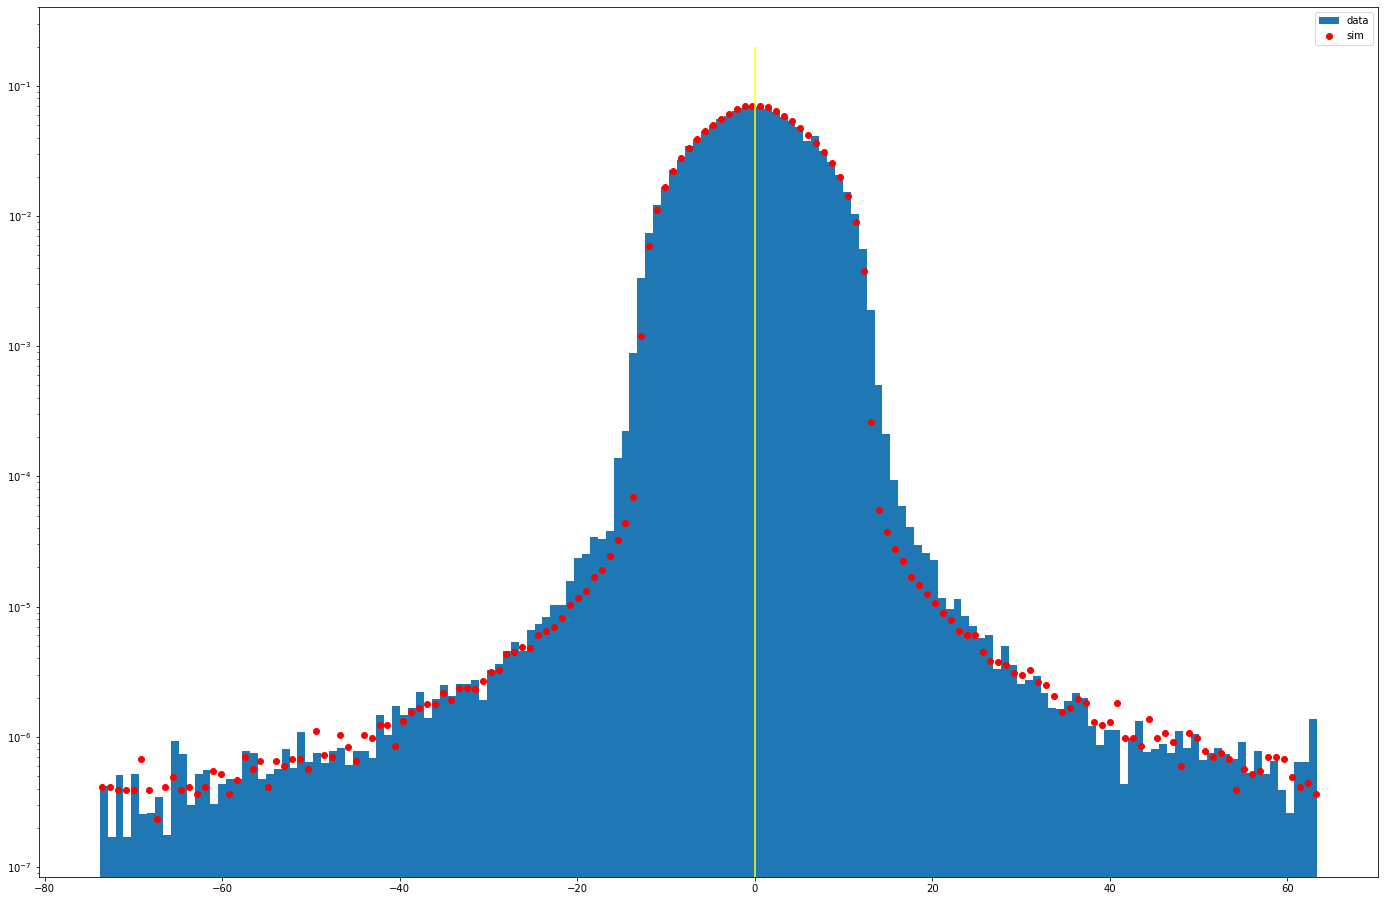

In [89]:
alpide_sim= np.loadtxt("../../../simulations/notebook/AlpideHistoSim_dcolcol18.txt")
alpide_sim= alpide_sim[np.logical_and(alpide_sim[:,0]>min(alpide_data_centered),alpide_sim[:,0]<max(alpide_data_centered))]

norm = np.sum(alpide_sim)*(alpide_sim[1,0]-alpide_sim[0,0])

plt.figure(figsize=(24,16))
plt.hist(alpide_data_centered, weights=alpide_weight, bins=len(alpide_sim), density=True, label="data")
#plt.scatter(alpide_sim[:,0]+x_mean, alpide_sim[:,1]/norm, color='red', zorder=1000, label="sim")
plt.scatter(alpide_sim[:,0], alpide_sim[:,1]/norm, color='red', zorder=1000, label="sim")
plt.vlines(0,0,0.2, color='yellow', zorder=10000)
plt.yscale("log")
plt.legend()

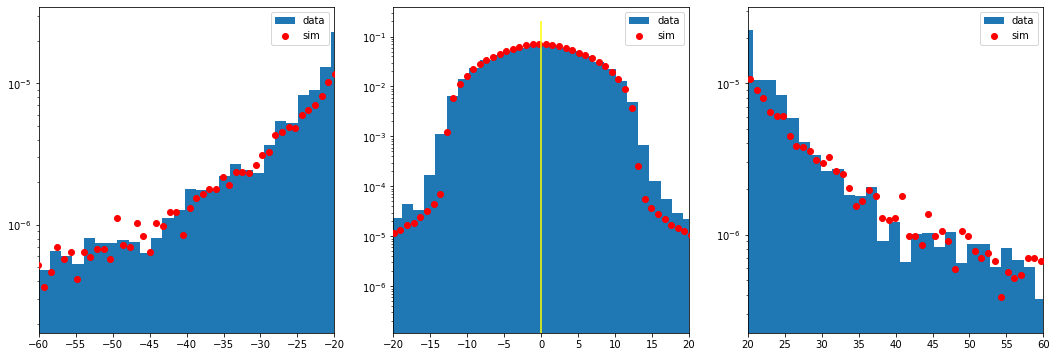

In [74]:
fig, axs = plt.subplots(1,3, figsize=(18, 6))


axs[0].hist(alpide_data_centered, weights=alpide_weight, bins=90, density=True, label="data")
axs[0].scatter(alpide_sim[:,0], alpide_sim[:,1]/norm, color='red', zorder=1000, label="sim")
axs[0].set_xlim(-60,-20)
axs[0].set_ylim(alpide_sim[np.argmin(abs(-60-alpide_sim[:,0])), 1]/3/norm,
                alpide_sim[np.argmin(abs(-20-alpide_sim[:,0])), 1]*3/norm)
axs[0].set_yscale("log")
axs[0].legend()

axs[1].hist(alpide_data_centered, weights=alpide_weight, bins=90, density=True, label="data")
axs[1].scatter(alpide_sim[:,0], alpide_sim[:,1]/norm, color='red', zorder=1000, label="sim")
axs[1].vlines(0,0,0.2, color='yellow', zorder=10000)
axs[1].set_xlim(-20,20)
axs[1].set_yscale("log")
axs[1].legend()

axs[2].hist(alpide_data_centered, weights=alpide_weight, bins=90, density=True, label="data")
axs[2].scatter(alpide_sim[:,0], alpide_sim[:,1]/norm, color='red', zorder=1000, label="sim")
axs[2].set_xlim(20,60)
axs[2].set_ylim(alpide_sim[np.argmin(abs(60-alpide_sim[:,0])), 1]/3/norm,
                alpide_sim[np.argmin(abs(20-alpide_sim[:,0])), 1]*3/norm)
axs[2].set_yscale("log")
axs[2].legend()

# X-Y area mapping

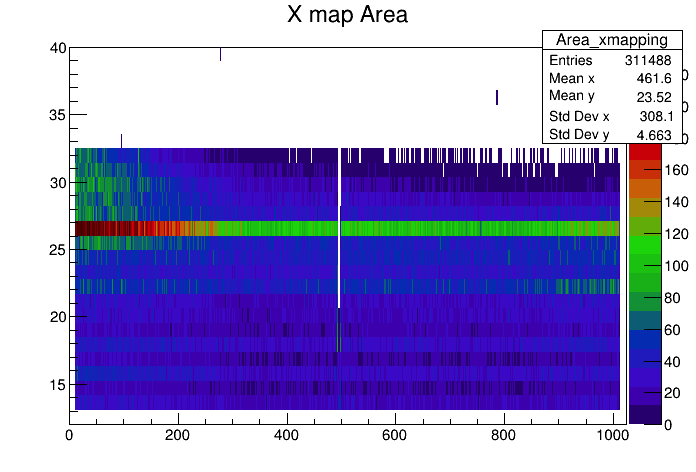

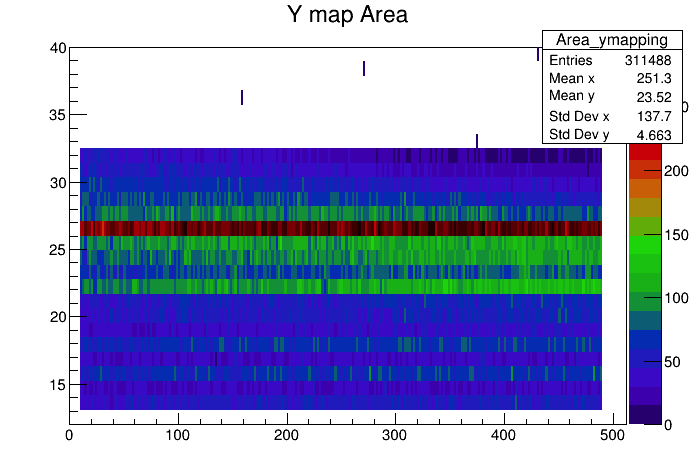

In [75]:
#ROOT.enableJSVis()
ROOT.disableJSVis()

Area_nbins=40-Area_thr-1

Area_xmapping = ROOT.TH2D('Area_xmapping','X map Area',512,0,1024,Area_nbins,Area_thr-1,40)

for coordinate,Area in zip(Means_disc,Areas_disc):
    Area_xmapping.Fill(coordinate[0],Area)
    
ROOT.gStyle.SetPalette(107)
    
HAXM=ROOT.TCanvas()
Area_xmapping.Draw('COLZ')
HAXM.Draw()

Area_ymapping = ROOT.TH2D('Area_ymapping','Y map Area',256,0,512,Area_nbins,Area_thr-1,40)

for coordinate,Area in zip(Means_disc,Areas_disc):
    Area_ymapping.Fill(coordinate[1],Area)
    
ROOT.gStyle.SetPalette(107)
    
HAYM=ROOT.TCanvas()
Area_ymapping.Draw('COLZ')
HAYM.Draw()


# Theta area mapping

In [ ]:
Area_nbins=40-Area_thr-1
nbins_theta=150

Area_thmapping = ROOT.TH2D('Area_thmapping','Theta map Area',nbins_theta,-80,80,Area_nbins,Area_thr-1,40)

for value,Area in zip(Theta_disc,Areas_disc):
    Area_thmapping.Fill(value*180/np.pi-center,Area,1/(ALPIDE_norm[int((thbins)*(value)/(th_max-th_min)+thbins/2)]))
    
ROOT.gStyle.SetPalette(107)
    
HATHM=ROOT.TCanvas()
Area_thmapping.Draw('COLZ')
#HATHM.SetLogz()
HATHM.Draw()

Area_thmapping_nd = ROOT.TH2D('Area_thmapping_nd','Theta map Area non discriminated',nbins_theta,-80,80,49,1,50)

for value,Area in zip(Theta,Areas):
    Area_thmapping_nd.Fill(value*180/np.pi-center,Area,1/(ALPIDE_norm[int((thbins)*(value)/(th_max-th_min)+thbins/2)]))
    
ROOT.gStyle.SetPalette(107)
Area_thmapping_nd.SetStats(False)
    
HATHMND=ROOT.TCanvas()
Area_thmapping_nd.Draw('COLZ')
HATHMND.Draw()



In [ ]:
PCAr_nbins=50
nbins_theta=150

PCAr_thmapping = ROOT.TH2D('PCAr_thmapping','Theta map PCAr',nbins_theta,-80,80,PCAr_nbins,0,Ratio_thr)

for value,PCAr in zip(Theta_disc,Ratios_disc):
    PCAr_thmapping.Fill(value*180/np.pi-center/180,PCAr,1/(ALPIDE_norm[int((thbins)*(value)/(th_max-th_min)+thbins/2)]))
    
ROOT.gStyle.SetPalette(107)
    
HPrTHM=ROOT.TCanvas()
PCAr_thmapping.Draw('COLZ')
HPrTHM.Draw()

PCAr_thmapping_nd = ROOT.TH2D('PCAr_thmapping_nd','Theta map PCAr non discriminated',nbins_theta,-80,80,2*PCAr_nbins,0,10)

for value,PCAr in zip(Theta,Ratios):
    PCAr_thmapping_nd.Fill(value*180/np.pi-center,PCAr,1/(ALPIDE_norm[int((thbins)*(value)/(th_max-th_min)+thbins/2)]))
    
ROOT.gStyle.SetPalette(107)
PCAr_thmapping_nd.SetStats(False)
    
HPrTHMND=ROOT.TCanvas()
PCAr_thmapping_nd.Draw('COLZ')
#HPrTHMND.SetLogz()
HPrTHMND.Draw()

# THR analysis
* Noise vs VCASN
* Area vs PCA ratio 2D Histo

In [ ]:
#Run packet analyzer script for all threshold
Data_folder_path="Data"
files=os.listdir(Data_folder_path+"/")
for name in files:
    if name.startswith('Data_VCASN_'):
        #analyze the data
        args = "-f "+name+" -Df "+Data_folder_path+" -d 1 10 "
        %run 'Packet_analyzer.py' {args}

In [ ]:
#Noise dependace on VCASN

VCASN_val    = []
Noise_points = []


files=os.listdir(Data_folder_path+"/")
for name in files:
    if name.startswith('Data_VCASN_'):
        V_CASN_THR=int(name.split('_')[2], base=16)
        VCASN_val = np.append(VCASN_val,V_CASN_THR)
        
        file=open("Data/"+name+"/Stat_"+name+".txt")
        line=file.readlines()
        for l in line:
            if (l.startswith("Readout_time")):
                time=float(l.split('=')[1].strip()[:-1])
            if (l.startswith("Strobe")):
                Strobe=int(l.split('=')[1].strip()[:-1])
            if (l.startswith("Gap")):
                Gap=int(l.split('=')[1].strip()[:-1])
        
        filename="Analyzed_Data/"+name+"/"+name+".root"
        root_file_1  = ROOT.TFile.Open(filename)
        Data_tree    = root_file_1.Get("tree")
        Noise        = Data_tree.AsMatrix(['Rnoise'])
        Noise_points = np.append(Noise_points,Noise[0]*(Strobe+Gap)/(time*Strobe))
        

In [ ]:
#plt.plot(VCASN_val,Noise_points, 'bo')
Noise_graph = ROOT.TGraph(len(Noise_points),VCASN_val,Noise_points)

Noise_graph.SetMarkerColor(4)
Noise_graph.SetMarkerStyle(2)
Noise_graph.SetMarkerSize(2)
YAxis = Noise_graph.GetYaxis()
YAxis.SetRangeUser(-1000,100000)

NPC = ROOT.TCanvas()

Noise_graph.Draw('AP')
NPC.Draw()

In [129]:
#convert the TTree in np arrays
name        = "gold_alpide_27_DC_5m_run4_090121"
filename    = "Analyzed_Data/"+name+"/"+name+".root"
root_file = ROOT.TFile.Open(filename)
Data_tree   = root_file.Get("tree")

Areas_AxP  = Data_tree.AsMatrix(['Rareas'])
Means_AxP  = Data_tree.AsMatrix(['Rmeanx','Rmeany'])
Ratios_AxP = Data_tree.AsMatrix(['Rratios'])

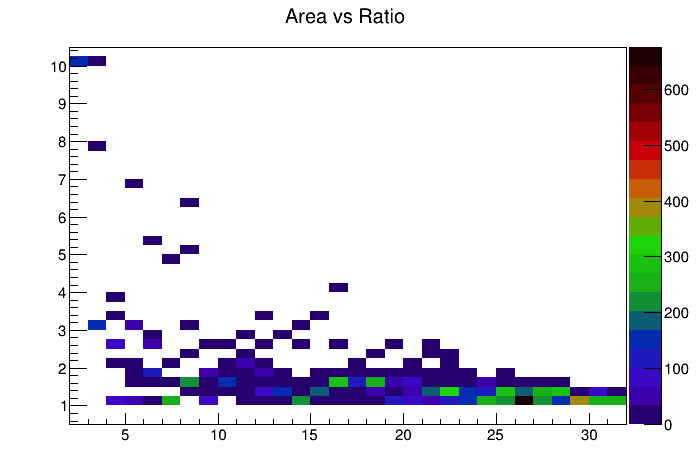

In [130]:
ar_max=int(np.amax(Areas_AxP))
A_R_Histo = ROOT.TH2D('A_R_Histo','Area vs Ratio',ar_max-2,2,ar_max,40,0.5,10.5)

for i in range(len(Areas_AxP)):
    A_R_Histo.Fill(Areas_AxP[i],Ratios_AxP[i])
    
    
ARC=ROOT.TCanvas()
A_R_Histo.Draw("COLZ")
A_R_Histo.SetStats(False)
ARC.Draw()

IndexError: range object index out of range

In [32]:
a=range(5)
print(a)
a=np.append(a,5)
print(a)
a=np.append(a,6)
print(a)

range(0, 5)
[0 1 2 3 4 5]
[0 1 2 3 4 5 6]
